In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils.prepare_dataset import prepare_dataset_mnist

In [41]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [42]:
max_seq_len = 64
batch_size = 64
dataset_size = 2000
with_mask = False

train_tokens, train_labels, train_mask, val_tokens, val_labels, val_mask = prepare_dataset_mnist(file="dataset/building_shapes_5010.csv",
                                                                                                 with_mask=with_mask,
                                                                                                 split_ratio=0.2,
                                                                                                 dataset_size=dataset_size,
                                                                                                 max_seq_len=max_seq_len,
                                                                                                 train=True)

train_tokens = train_tokens[:, :, :2]
val_tokens = val_tokens[:, :, :2]

train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

In [43]:
def right_shift_3d_tensor(tensor):
    # Create a zero tensor with the same size as the input tensor
    shifted_tensor = torch.zeros_like(tensor)
    
    # Shift the tensor along dimension 1
    shifted_tensor[:, 1:, :] = tensor[:, :-1, :]

    return shifted_tensor

# Define the encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, input_seq):
        _, (h, c) = self.lstm(input_seq)
        return h, c

# Define the decoder
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, h, c):
        batch_size, seq_len, _ = input_seq.shape
        hidden = h.reshape(batch_size, 1, -1)
        z = hidden.repeat(1, seq_len, 1)
        # input_seq = torch.cat([z, input_seq], dim=-1)
        input_seq = z
        output, _ = self.lstm(input_seq)
        output = self.fc(output)
        return hidden, output


class LstmAE(nn.Module):
    def __init__(self, fea_dim, hidden_size):
        super().__init__()
        self.encoder = Encoder(fea_dim, hidden_size)
        self.decoder = Decoder(hidden_size, hidden_size, fea_dim)
        self.loss_func = nn.MSELoss()
    
    def forward(self, x):
        h, c = self.encoder(x)
        output = self.decoder(x, h, c)
        hidden, output = self.decoder(x, h, c)
        loss = self.loss_func(output, x)
        return hidden, output, loss

In [34]:
lstm_ae = LstmAE(fea_dim=2, hidden_size=128)
optimizer = optim.Adam(lstm_ae.parameters(), lr=0.004)

num_epoch = 20

for epoch in range(num_epoch):
    lstm_ae.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        hidden, outputs, loss = lstm_ae(inputs)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss/len(train_loader)

    lstm_ae.eval()
    with torch.no_grad():
        val_hidden, val_outputs, loss = lstm_ae(train_tokens)
        val_loss = loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch 1, Train Loss: 0.27745760560035704, Val Loss: 0.26746898889541626
Epoch 2, Train Loss: 0.22184552729129792, Val Loss: 0.18145149946212769
Epoch 3, Train Loss: 0.15176959753036498, Val Loss: 0.12396850436925888
Epoch 4, Train Loss: 0.11920574694871902, Val Loss: 0.1125035285949707
Epoch 5, Train Loss: 0.10477832794189453, Val Loss: 0.10098492354154587
Epoch 6, Train Loss: 0.09943959027528763, Val Loss: 0.09634427726268768
Epoch 7, Train Loss: 0.09517864421010018, Val Loss: 0.08854621648788452
Epoch 8, Train Loss: 0.09092173486948013, Val Loss: 0.08374664187431335
Epoch 9, Train Loss: 0.08286684677004814, Val Loss: 0.0783134400844574
Epoch 10, Train Loss: 0.07835365995764733, Val Loss: 0.07641127705574036
Epoch 11, Train Loss: 0.07421459704637527, Val Loss: 0.06982933729887009
Epoch 12, Train Loss: 0.07065812900662422, Val Loss: 0.06915997713804245
Epoch 13, Train Loss: 0.06688089877367019, Val Loss: 0.06374228745698929
Epoch 14, Train Loss: 0.060666752755641935, Val Loss: 0.057869

In [50]:
# # Save the model
# torch.save(lstm_ae.state_dict(), 'lstm_ae_2k_lr004_e50_with_p_model.pth')

lstm_ae = LstmAE(fea_dim=2, hidden_size=128)
lstm_ae.load_state_dict(torch.load('lstm_ae_2k_lr004_e200_model.pth'))

with torch.no_grad():
    val_hidden, val_outputs, loss = lstm_ae(train_tokens)

In [51]:
from utils.embeding_evaluate import compute_NN, compute_FT, compute_ST

show_hidden = val_hidden.reshape(val_hidden.size(0), -1)
show_labels = train_labels

"Embedding", compute_NN(show_hidden, show_labels), compute_FT(show_hidden, show_labels), compute_ST(show_hidden, show_labels)

('Embedding', 0.835, 0.19738792406761757, 0.29703629154397715)

In [52]:
show_hidden = train_tokens.reshape(train_tokens.size(0), -1)
show_labels = train_labels

"Original", compute_NN(show_hidden, show_labels), compute_FT(show_hidden, show_labels), compute_ST(show_hidden, show_labels)

('Original', 0.80875, 0.1946533983245083, 0.2957395614116295)

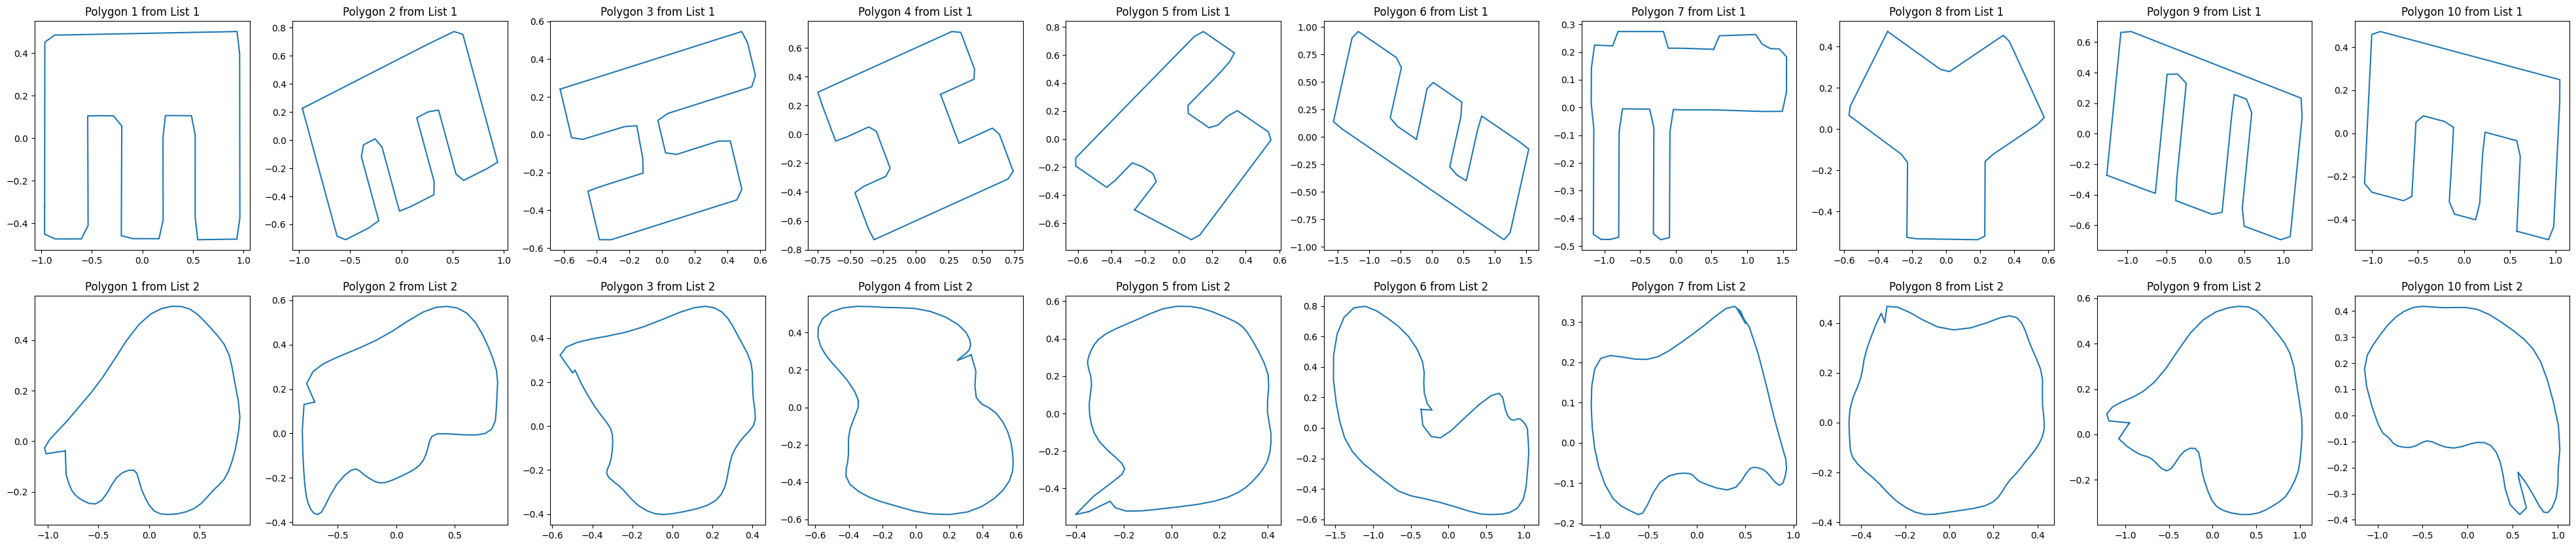

In [35]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

num_samples = 10

show_shapes = train_tokens[:num_samples]
rec_shapes = val_outputs[:num_samples]

ori_polygons = [Polygon(vec) for vec in show_shapes]
new_polygons = [Polygon(vec) for vec in rec_shapes]

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))

# Plot polygons from the first list
for i, polygon in enumerate(ori_polygons):
    axs[0, i].set_title('Polygon {} from List 1'.format(i+1))
    x, y = polygon.exterior.xy
    axs[0, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[0, i].plot(hole_x, hole_y)

# Plot polygons from the second list
for i, polygon in enumerate(new_polygons):
    axs[1, i].set_title('Polygon {} from List 2'.format(i+1))
    x, y = polygon.exterior.xy
    axs[1, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[1, i].plot(hole_x, hole_y)

# Show the plot
plt.show()

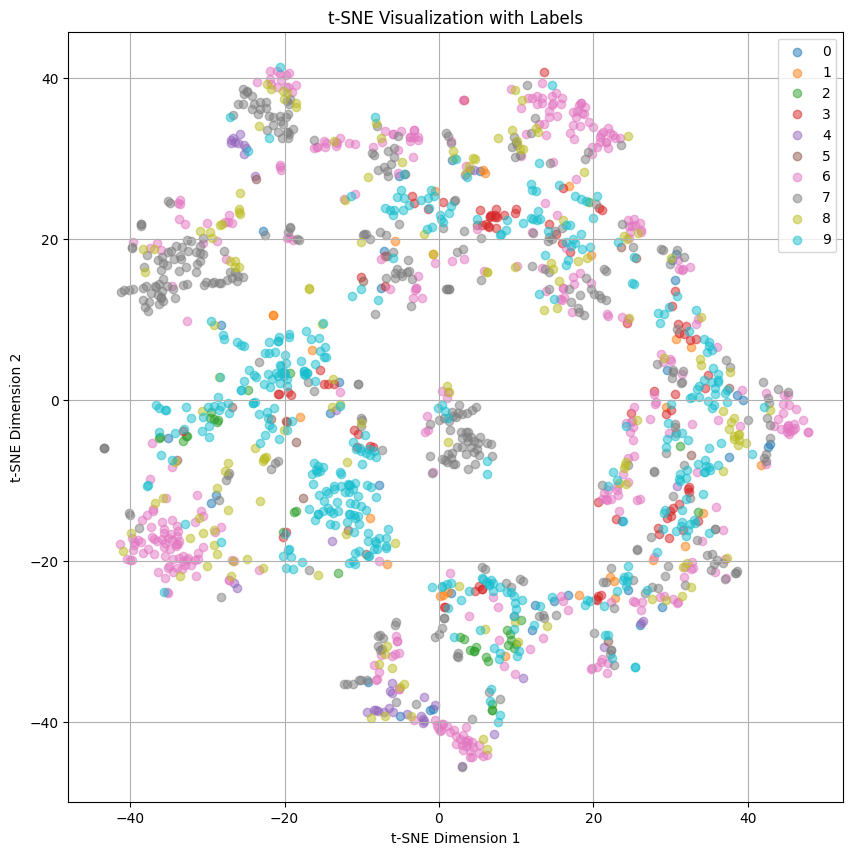

In [36]:
# show_hidden = val_tokens.view(val_tokens.size(0), -1)
show_hidden = val_hidden.reshape(val_hidden.size(0), -1)
show_labels = train_labels


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


tsne = TSNE(n_components=2, init='pca', random_state=0)
projections = tsne.fit_transform(show_hidden)

plt.figure(figsize=(10, 10))

# Plot each class separately
for label in np.unique(show_labels):
    indices = show_labels == label
    plt.scatter(projections[indices, 0], projections[indices, 1], label=label, alpha=0.5)

plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
lstm_ae.eval()
with torch.no_grad():
    cls_train_hidden = lstm_ae(train_tokens)[0].view(train_tokens.size(0), -1)
    cls_val_hidden = lstm_ae(val_tokens)[0].view(val_tokens.size(0), -1)

# Without encoding
cls_train_hidden = train_tokens.reshape(train_tokens.size(0), -1)
cls_val_hidden = val_tokens.reshape(val_tokens.size(0), -1)

cls_train_loader = DataLoader(TensorDataset(cls_train_hidden, train_labels), batch_size=batch_size, shuffle=True)

In [39]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_size, dense_size, num_classes, dropout):
        super().__init__()
        self.dense1 = nn.Linear(input_size, dense_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        # # Linear probing
        # x = self.dense1(x)

        return x
    
classifier = Classifier(cls_train_hidden.size(1), 128, 10, 0.0)

if USE_GPU:
    classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.004)
# optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epochs = 300

def train(model, loader):
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, dim=-1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, tokens, labels):
    model.eval()
    with torch.no_grad():
        if USE_GPU:
            tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        eval_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim=-1)
        eval_acc = (predicted == labels).sum().item() / labels.size(0)
    return eval_loss, eval_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, cls_train_loader)
    val_loss, val_acc = evaluate(classifier, cls_val_hidden, val_labels)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Train Acc {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")


# # Test
# test_loss, test_acc = evaluate(classifier, test_loader)
# print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 1, Train Loss: 1.923379168510437, Train Acc 0.34125, Val Loss: 1.731132984161377, Val Acc: 0.4175
Epoch: 2, Train Loss: 1.6574721813201905, Train Acc 0.421875, Val Loss: 1.6613720655441284, Val Acc: 0.455
Epoch: 3, Train Loss: 1.5348814916610718, Train Acc 0.49375, Val Loss: 1.5564428567886353, Val Acc: 0.4925
Epoch: 4, Train Loss: 1.4281533527374268, Train Acc 0.52625, Val Loss: 1.4904626607894897, Val Acc: 0.525
Epoch: 5, Train Loss: 1.3346400213241578, Train Acc 0.5525, Val Loss: 1.4238600730895996, Val Acc: 0.54
Epoch: 6, Train Loss: 1.2685110664367676, Train Acc 0.561875, Val Loss: 1.4180994033813477, Val Acc: 0.5425
Epoch: 7, Train Loss: 1.2092872476577758, Train Acc 0.5825, Val Loss: 1.3745394945144653, Val Acc: 0.565
Epoch: 8, Train Loss: 1.1569581460952758, Train Acc 0.601875, Val Loss: 1.310357928276062, Val Acc: 0.5775
Epoch: 9, Train Loss: 1.1153707265853883, Train Acc 0.619375, Val Loss: 1.294398546218872, Val Acc: 0.585
Epoch: 10, Train Loss: 1.0764327931404114, Tr

KeyboardInterrupt: 